In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 120, "savefig.dpi": 300})

warnings.filterwarnings("ignore")

DATA_DIR = Path("../Data")
OUT_DIR = Path("../Data_plot/figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def load_data(path: Path) -> pd.DataFrame:
    """Load CSV or Parquet into a cleaned DataFrame."""
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(path)

    if path.suffix.lower() in [".csv"]:
        df = pd.read_csv(path)
    elif path.suffix.lower() in [".parquet", ".pq"]:
        df = pd.read_parquet(path)
    else:
        raise ValueError("Unsupported file type: %s" % path.suffix)

    df = df.dropna(how="all")
    df.columns = [c.strip() for c in df.columns]
    return df

In [3]:
def ensure_numeric(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


def prepare_dataframe(df: pd.DataFrame, required: list | None = None) -> pd.DataFrame:
    """Ensure required columns and sensible dtypes; return a cleaned copy."""
    df = df.copy()
    if required:
        missing = [c for c in required if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns: {missing}")
    df = ensure_numeric(df, [c for c in df.columns if df[c].dtype == object])
    return df


def compute_group_metrics(df: pd.DataFrame, groupby: list, agg: dict) -> pd.DataFrame:
    """Return aggregated metrics using groupby+agg."""
    return df.groupby(groupby).agg(agg).reset_index()


In [4]:
def rescale_series(s: pd.Series, scale: float = 1.0) -> pd.Series:
    return (s - s.min()) / (s.max() - s.min()) * scale


In [5]:
def plot_series(ax, x, y, err=None, label=None, color=None, **kwargs):
    ax.plot(x, y, label=label, color=color, **kwargs)
    if err is not None:
        ax.fill_between(x, y - err, y + err, color=color, alpha=0.2)
    return ax


def plot_heatmap(ax, data, x=None, y=None, cbar=True, **kwargs):
    im = ax.imshow(data, aspect="auto", origin="lower", **kwargs)
    if cbar:
        plt.colorbar(im, ax=ax)
    return ax


In [6]:
FIGSIZE = (6, 4)
PALETTE = sns.color_palette("tab10")

In [7]:
def save_figure(fig, path: Path, dpi: int = 300, **kwargs):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=dpi, bbox_inches="tight", **kwargs)


def save_data(df: pd.DataFrame, path: Path):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    if path.suffix == ".csv":
        df.to_csv(path, index=False)
    else:
        df.to_parquet(path, index=False)


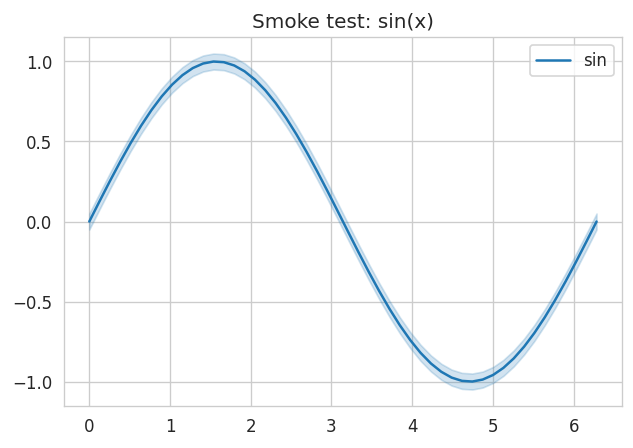

In [8]:
def _smoke_test_load_and_plot():
    x = np.linspace(0, 2 * np.pi, 50)
    y = np.sin(x)
    err = 0.05 * np.ones_like(x)

    fig, ax = plt.subplots(figsize=FIGSIZE)
    plot_series(ax, x, y, err=err, label="sin", color=PALETTE[0])
    ax.set_title("Smoke test: sin(x)")
    ax.legend()
    plt.show()


_smoke_test_load_and_plot()


In [ ]:
fontsize = 14
plt.rcParams.update({"font.size": fontsize})


In [ ]:
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lam = 0.5
L = 9
file_name = f"../Data/phase_diagram/lam_{lam}_L_{L}.csv"
df = pd.read_csv(file_name)
ks_all = df['k'].unique()
hs_all = df['h'].unique()
E_all = df.pivot(index='h', columns='k', values='E').values
folder = f"../Data/fixed_points_test/cRBM_lam_{lam}_L_{L}"

def take_data(file_name):
    df = pd.read_csv(file_name)
    ks = df['ks'].to_numpy()
    hs = df['hs'].to_numpy()
    E_ED = np.array(df['E_ED'].to_numpy(), dtype=complex)
    E_nk = np.array(df['E_nk'].to_numpy(), dtype=complex)
    E_exact = np.array(df['E_exact'].to_numpy(), dtype=complex)
    F_exact = np.array(df['F_exact'].to_numpy(), dtype=complex)
    F_nk = np.array(df['F_nk'].to_numpy(), dtype=complex)
    mask = (E_ED.imag * E_nk.imag < 0)
    E_ED = np.where(mask, E_ED.conj(), E_ED)
    mask = (E_exact.imag * E_ED.imag < 0)
    E_exact = np.where(mask, E_exact.conj(), E_exact)
    relative_error_nk = np.abs(E_ED - E_nk) / np.abs(E_ED)
    relative_error_exact = np.abs(E_ED - E_exact) / np.abs(E_ED)
    sort_indices = np.lexsort((ks, hs))
    ks = ks[sort_indices]
    hs = hs[sort_indices]
    E_ED = E_ED[sort_indices]
    E_nk = E_nk[sort_indices]
    E_exact = E_exact[sort_indices]
    F_exact = F_exact[sort_indices]
    F_nk = F_nk[sort_indices]
    mask = (E_ED.imag * E_nk.imag < 0)
    E_ED = np.where(mask, E_ED.conj(), E_ED)
    mask = (E_exact.imag * E_ED.imag < 0)
    E_exact = np.where(mask, E_exact.conj(), E_exact)
    relative_error_nk = np.abs(E_ED - E_nk) / np.abs(E_ED)
    relative_error_exact = np.abs(E_ED - E_exact) / np.abs(E_ED)
    return relative_error_nk, relative_error_exact, ks, hs

re_nk_SC, re_exact_SC, ks, hs = take_data(folder + "_AllSR_4000_z.csv")
re_nk_par, re_exact_par, _, _ = take_data(folder + "_AllSR_par_4000.csv")
re_nk_CC, re_exact_CC, _, _ = take_data(folder + "_CC_4000.csv")
re_nk_SC_grid = re_nk_SC.reshape((11, 11))
re_nk_CC_grid = re_nk_CC.reshape((11, 11))
re_nk_par_grid = re_nk_par.reshape((11, 11))
re_exact_SC_grid = re_exact_SC.reshape((11, 11))
re_exact_CC_grid = re_exact_CC.reshape((11, 11))
re_exact_par_grid = re_exact_par.reshape((11, 11))
E_nk_im_grid = np.array(re_nk_CC_grid).imag if hasattr(re_nk_CC_grid, 'imag') else np.array(re_nk_CC_grid)
col_titles = ['Self-Consistent Method', 'Self-Consistent Method', 'Energy as a Parameter Method']
grids = [[re_nk_SC_grid, re_nk_CC_grid, re_nk_par_grid], [re_exact_SC_grid, re_exact_CC_grid, re_exact_par_grid]]
all_data = [re_nk_CC_grid, re_nk_par_grid]
vmin = min(np.min(grid) for grid in all_data)
vmax = max(np.max(grid) for grid in all_data)
fig, axes = plt.subplots(1, 3, figsize=(6.4 * 3, 4.8))
ax = axes[0]
im0 = ax.imshow(np.abs(E_nk_im_grid), extent=[ks_all[0] / 0.5, ks_all[-1] / 0.5, hs_all[0] / 0.5, hs_all[-1] / 0.5], origin='lower', aspect='auto', cmap='plasma')
fig.colorbar(im0, ax=ax).set_label(r"$\Im(E)$", fontsize=fontsize)
ax.plot((ks / 0.5), (hs / 0.5), color='red', linestyle='--')
ax.text(0.4 / 0.5, 2.4 / 0.5, r"$\mathcal{PT}$", fontsize=25, color='white')
ax.text(1.9 / 0.5, 1.4 / 0.5, r"$\mathcal{bPT}$", fontsize=25, color='black')
ax.set_xlabel(r"$k/\lambda$")
ax.set_ylabel(r"$h/\lambda$")
ax.set_title("(a)", loc="left", fontweight="bold")
col_indices = [2, 1]
for plot_idx, col in enumerate(col_indices, start=1):
    ax = axes[plot_idx]
    imshow_obj = ax.imshow(grids[0][col], cmap='viridis', origin='lower', aspect='auto', extent=[ks_all[0] / 0.5, ks_all[-1] / 0.5, hs_all[0] / 0.5, hs_all[-1] / 0.5], norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_xlabel(r"$k/\lambda$")
    ax.set_ylabel(r"$h/\lambda$")
    cbar = fig.colorbar(imshow_obj, ax=ax)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(r"$\epsilon_{rel}$", fontsize=fontsize)
    ax.plot((ks / 0.5), (hs / 0.5), color='red', linestyle='--')
    ax.set_title(f"({chr(ord('a') + plot_idx)})", loc="left", fontweight="bold")
plt.tight_layout()
plt.savefig("Figures/method_comparison.pdf")
plt.show()


In [ ]:
L = 20
lam = 0.5
file_name = f"../Data/warm_start_CC/plot_observables/MC_cRBM_lam_{lam}_L_{L}_PBC_1_dim.csv"
file_name_rev = f"../Data/warm_start_CC/plot_observables/MC_cRBM_lam_{lam}_L_{L}_PBC_1_dim_rev.csv"
df = pd.read_csv(file_name)
df_rev = pd.read_csv(file_name_rev)
hs_array = df['hs'].to_numpy(dtype=float)
seen = set()
unique_hs = [h for h in hs_array if not (h in seen or seen.add(h))]
grouped_data = {}
for h in unique_hs:
    mask = df['hs'] == h
    grouped_data[h] = {
        'ks': df.loc[mask, 'ks'].to_numpy(dtype=float),
        'E_ED': df.loc[mask, 'Gs_exact'].to_numpy(dtype=complex),
        'E_warm': df.loc[mask, 'E_estimate'].to_numpy(dtype=complex),
        're': df.loc[mask, 're_E'].to_numpy(dtype=float),
        'M_z_exact': df.loc[mask, 'M_z_exact'].to_numpy(dtype=float),
        'M_z_estimate': df.loc[mask, 'M_z_estimate'].to_numpy(dtype=float),
        'M_x_exact': df.loc[mask, 'M_x_exact'].to_numpy(dtype=float),
        'M_x_estimate': df.loc[mask, 'M_x_estimate'].to_numpy(dtype=float),
    }
h = 1.5
sort_idx = np.argsort(grouped_data[h]['ks'])
for key in grouped_data[h]:
    grouped_data[h][key] = grouped_data[h][key][sort_idx]
ks_to_remove = np.linspace(0, 0.6, 20)[13:]
ks = grouped_data[h]['ks']
mask = ~np.any(np.isclose(ks[:, None], ks_to_remove[None, :]), axis=1)
for key in grouped_data[h]:
    grouped_data[h][key] = grouped_data[h][key][mask]
df_rev = df_rev.sort_values(by='ks')
k_values_to_remove = np.linspace(0, 0.6, 20)[14:-1]
ks_array = df_rev['ks'].to_numpy(dtype=float)
remove_mask = np.any(np.isclose(ks_array[:, None], k_values_to_remove[None, :], atol=1e-8), axis=1)
df_rev = df_rev[~remove_mask]
df_rev['ks_rounded'] = df_rev['ks'].round(5)
df_rev = df_rev.drop_duplicates(subset='ks_rounded', keep='first')
df_rev = df_rev.drop(columns='ks_rounded')
ks_rev = df_rev['ks'].to_numpy(dtype=float)
re_rev = df_rev['re_E'].to_numpy(dtype=float)
E_ED_rev = df_rev['Gs_exact'].to_numpy(dtype=complex)
E_estimate_rev = df_rev['E_estimate'].to_numpy(dtype=complex)
mask = (E_ED_rev.imag * E_estimate_rev.imag < 0)
E_ED_rev = np.where(mask, E_ED_rev.conj(), E_ED_rev)
re_rev = np.abs(E_ED_rev - E_estimate_rev) / np.abs(E_ED_rev)
file_name = f"../Data/fixed_start_CC/plot_observables/MC_cRBM_lam_{lam}_L_{L}_PBC_1_dim.csv"
df = pd.read_csv(file_name)
ks_fixed = df['ks'].to_numpy(dtype=float)
re_fixed = df['re_E'].to_numpy(dtype=float)
E_ED_fixed = df['Gs_exact'].to_numpy(dtype=complex)
E_estimate_fixed = df['E_estimate'].to_numpy(dtype=complex)
mask = (E_ED_fixed.imag * E_estimate_fixed.imag < 0)
E_ED_fixed = np.where(mask, E_ED_fixed.conj(), E_ED_fixed)
re_fixed = np.abs(E_ED_fixed - E_estimate_fixed) / np.abs(E_ED_fixed)

k_EP = 0.45263157894736844
colors = plt.cm.viridis(np.linspace(0, 0.5, 3))
ks = grouped_data[1.5]['ks']
re = grouped_data[1.5]['re']
plt.figure(figsize=(8,4))
plt.scatter(ks_fixed/0.5, re_fixed, color=colors[2], label=r"Fixed Start", zorder=5)
plt.plot(ks/0.5, re, linestyle="--", marker=">", color=colors[0], label=r"Increasing $k$")
plt.plot(ks_rev/0.5, re_rev, linestyle="--", marker="<", color=colors[1], label=r"Decreasing $k$")
plt.axvline(x=k_EP/0.5, color='red', linestyle='--', alpha=0.5, label='EP')
plt.legend(loc='upper left')
plt.xlabel(r"$k/\lambda$", fontsize=fontsize)
plt.ylabel(r"$\epsilon_{rel}$", fontsize=fontsize)
plt.yscale('log')
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(0/0.5, 0.85/0.5)
plt.savefig('Figures/around_EP.pdf')
plt.show()


In [ ]:
lam = 0.5
n_dim = 2
L = 6
hs = [2, 2.25]
OBC = 'PBC'
M_x_estimate = []
M_z_estimate = []
M_x_LR_estimate = []
M_z_LR_estimate = []
M_x_DMRG = []
M_z_DMRG = []
E_warm = []
es_dmrg = []
re = []
for h in hs:
    file_name = f"../Data/warm_start_CC/plot_observables/MC_cRBM_lam_{lam}_L_{L}_{OBC}_{n_dim}_dim.csv"
    df = pd.read_csv(file_name)
    df = df[df['hs'] == h]
    ks = df['ks'].to_numpy(dtype=float)
    E_warm.append(df['E_estimate'].to_numpy(dtype=complex))
    M_z_estimate.append(df['M_z_estimate'].to_numpy(dtype=float))
    M_x_estimate.append(df['M_x_estimate'].to_numpy(dtype=float))
    M_z_LR_estimate.append(df['M_z_LR_estimate'].to_numpy(dtype=complex))
    M_x_LR_estimate.append(df['M_x_LR_estimate'].to_numpy(dtype=complex))
    df = pd.read_csv(f"../Data/DMRG/line/lam_{lam}_N_{L}_PBC_true_obs.csv")
    df = df[df['h'] == h]
    df = df.sort_values(by='k')
    M_x_DMRG.append(df['magx'].to_numpy(dtype=float))
    M_z_DMRG.append(df['magz'].to_numpy(dtype=float))
    e_dmrg = df['energy'].apply(lambda z: str(z).replace('im', 'j').replace(' ', '')).to_numpy(dtype=complex)
    mask = (e_dmrg.imag * E_warm[-1].imag < 0)
    es_dmrg.append(np.where(mask, e_dmrg.conj(), e_dmrg))
    re.append(np.abs(es_dmrg[-1] - E_warm[-1]) / np.abs(es_dmrg[-1]))
which = 0
colors = plt.cm.viridis(np.linspace(0, 0.75, len(hs) + 2))
ks_rescaled = ks / 0.5
fig = plt.figure(figsize=(6.4 * 3, 4.8))
from matplotlib import gridspec
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], wspace=0.3, hspace=0.4)
ax_EP = fig.add_subplot(gs[:, 0])
ax_re = fig.add_subplot(gs[0, 1])
ax_im = fig.add_subplot(gs[1, 1])
ax_mag = fig.add_subplot(gs[:, 2])
# reuse the around-EP plot (recompute if needed)
plot_around_EP = None
try:
    plot_around_EP
except NameError:
    pass
ax_EP.set_title('(a)', loc='left', fontsize=fontsize, fontweight='bold')
for i, h in enumerate(hs):
    color = colors[i]
    ax_re.plot(ks_rescaled, es_dmrg[i].real, linestyle='--', marker='o', markerfacecolor='white', markersize=7, color=color, zorder=1)
    ax_re.scatter(ks_rescaled, E_warm[i].real, marker='o', s=5, color=color, zorder=2)
    ax_im.plot(ks_rescaled, es_dmrg[i].imag, linestyle='--', marker='o', markerfacecolor='white', markersize=7, color=color, zorder=1)
    ax_im.scatter(ks_rescaled, E_warm[i].imag, marker='o', s=5, color=color, zorder=2)
    ax_mag.plot(ks_rescaled, np.abs(M_x_DMRG[i]), linestyle='--', marker='o', markerfacecolor='white', markersize=7, color=color, zorder=1, label='DMRG $M_x$')
    ax_mag.plot(ks_rescaled, np.abs(M_z_DMRG[i]), linestyle='--', marker='s', markerfacecolor='white', markersize=7, color=color, zorder=1, label='DMRG $M_z$')
    ax_mag.scatter(ks_rescaled, np.abs(M_x_estimate[i]), marker='o', s=5, color=color, label='NQS $M_x$')
    ax_mag.scatter(ks_rescaled, np.abs(M_z_estimate[i]), marker='s', s=5, color=color, label='NQS $M_z$')
for ax in [ax_re, ax_im, ax_mag]:
    ax.set_xlabel(r"$k/\lambda$", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.grid(linestyle='--', alpha=0.5)
ax_re.set_ylabel(r"$\Re(E)$", fontsize=fontsize)
ax_im.set_ylabel(r"$\Im(E)$", fontsize=fontsize)
ax_mag.set_ylabel('Magnetization', fontsize=fontsize)
ax_re.set_title('(b)', loc='left', fontsize=fontsize, fontweight='bold')
ax_im.set_title('(c)', loc='left', fontsize=fontsize, fontweight='bold')
ax_mag.set_title('(d)', loc='left', fontsize=fontsize, fontweight='bold')
plt.tight_layout()
plt.savefig('Figures/warm_start_with_EP.pdf', bbox_inches='tight')
plt.show()


In [ ]:
n_dim = 2
Ls = [4, 5, 6, 8]
lam = 0.5
hs = [2.75, 0.5]
ks = [0.25, 1]
PBC = True
folder = "../Data/fixed_start_CC/plot_observables/"
folder_herm = "../Data/Hermitian/plot_observables/"
r = []
cc_r_all = []
cc_r_err_all = []
cc_r_LR_all = []
cc_r_LR_err_all = []
cc_r_herm_all = []
cc_r_herm_err_all = []
c_r_all = []
c_r_err_all = []
c_r_LR_all = []
c_r_LR_err_all = []
c_r_herm_all = []
c_r_herm_err_all = []
M_z_all = []
M_z_err_all = []
M_z_LR_all = []
M_z_LR_err_all = []
M_z_herm_all = []
M_z_herm_err_all = []
for L in Ls:
    df_all = pd.read_csv(folder + f"MC_cRBM_lam_{lam}_L_{L}_PBC_{n_dim}_dim_err.csv")
    df_herm_all = pd.read_csv(folder_herm + f"MC_cRBM_lam_{lam}_L_{L}_PBC_{n_dim}_dim_err.csv")
    r.append(np.unique(df_all['r'].to_numpy()))
    cc_r = []
    cc_r_err = []
    cc_r_LR = []
    cc_r_LR_err = []
    cc_r_herm = []
    cc_r_herm_err = []
    c_r = []
    c_r_err = []
    c_r_LR = []
    c_r_LR_err = []
    c_r_herm = []
    c_r_herm_err = []
    M_z = []
    M_z_err = []
    M_z_LR = []
    M_z_LR_err = []
    M_z_herm = []
    M_z_herm_err = []
    for h, k in zip(hs, ks):
        df = df_all[df_all['k'] == k]
        df_herm = df_herm_all[df_herm_all['k'] == k]
        cc_r.append(df['cc_r_z'].to_numpy(dtype=complex).real)
        cc_r_err.append(df['cc_r_z_err'].to_numpy(dtype=complex).real)
        cc_r_LR.append(df['cc_r_z_LR'].to_numpy(dtype=complex))
        cc_r_LR_err.append(df['cc_r_z_LR_err'].to_numpy(dtype=complex).real)
        cc_r_herm.append(df_herm['cc_r_z'].to_numpy(dtype=complex).real)
        cc_r_herm_err.append(df_herm['cc_r_z_err'].to_numpy(dtype=complex).real)
        c_r.append(df['c_r_z'].to_numpy(dtype=complex).real)
        c_r_err.append(df['c_r_z_err'].to_numpy(dtype=complex).real)
        c_r_LR.append(df['c_r_z_LR'].to_numpy(dtype=complex))
        c_r_LR_err.append(df['c_r_z_LR_err'].to_numpy(dtype=complex))
        c_r_herm.append(df_herm['c_r_z'].to_numpy(dtype=complex).real)
        c_r_herm_err.append(df_herm['c_r_z_err'].to_numpy(dtype=complex).real)
        M_z.append(np.unique(df['M_z'].to_numpy(dtype=complex).real)[0])
        M_z_err.append(np.unique(df['M_z_err'].to_numpy(dtype=complex).real)[0])
        M_z_LR.append(np.unique(df['M_z_LR'].to_numpy(dtype=complex))[0])
        M_z_LR_err.append(np.unique(df['M_z_LR_err'].to_numpy(dtype=complex))[0])
        M_z_herm.append(np.unique(df_herm['M_z'].to_numpy(dtype=complex))[0].real)
        M_z_herm_err.append(np.unique(df_herm['M_z_err'].to_numpy(dtype=complex))[0].real)
    cc_r_all.append(np.array(cc_r).reshape((len(ks), -1)))
    cc_r_err_all.append(np.array(cc_r_err).reshape((len(ks), -1)))
    cc_r_LR_all.append(np.array(cc_r_LR).reshape((len(ks), -1)))
    cc_r_LR_err_all.append(np.array(cc_r_LR_err).reshape((len(ks), -1)))
    cc_r_herm_all.append(np.array(cc_r_herm).reshape((len(ks), -1)))
    cc_r_herm_err_all.append(np.array(cc_r_herm_err).reshape((len(ks), -1)))
    c_r_all.append(np.array(c_r).reshape((len(ks), -1)))
    c_r_err_all.append(np.array(c_r_err).reshape((len(ks), -1)))
    c_r_LR_all.append(np.array(c_r_LR).reshape((len(ks), -1)))
    c_r_LR_err_all.append(np.array(c_r_LR_err).reshape((len(ks), -1)))
    c_r_herm_all.append(np.array(c_r_herm).reshape((len(ks), -1)))
    c_r_herm_err_all.append(np.array(c_r_herm_err).reshape((len(ks), -1)))
    M_z_all.append(np.array(M_z).reshape((len(ks))))
    M_z_err_all.append(np.array(M_z_err).reshape((len(ks))))
    M_z_LR_all.append(np.array(M_z_LR).reshape((len(ks))))
    M_z_LR_err_all.append(np.array(M_z_LR_err).reshape((len(ks))))
    M_z_herm_all.append(np.array(M_z_herm).reshape((len(ks))))
    M_z_herm_err_all.append(np.array(M_z_herm_err).reshape((len(ks))))
M_z_all = np.array(M_z_all)
M_z_err_all = np.array(M_z_err_all)
M_z_LR_all = np.array(M_z_LR_all)
M_z_LR_err_all = np.array(M_z_LR_err_all)
lam = 0.5
h = 2.75
k = 0.25
BC = 'PBC'
n_dim = 2
df_NQS = pd.read_csv(f"../Data/variance/cRBM_lam_{lam}_{BC}_{n_dim}_dim.csv")
df_DMRG_100 = pd.read_csv(f"../Data/DMRG/variance/h_{h}_k_{k}_DMRG_100.csv")
df_DMRG_500 = pd.read_csv(f"../Data/DMRG/variance/h_{h}_k_{k}_DMRG_500.csv")
df_DMRG_300 = pd.read_csv(f"../Data/DMRG/variance/h_{h}_k_{k}_DMRG_300.csv")
df_DMRG_700 = pd.read_csv(f"../Data/DMRG/variance/h_{h}_k_{k}_DMRG_700.csv")
df_DMRG_1000 = pd.read_csv(f"../Data/DMRG/variance/h_{h}_k_{k}_DMRG_1000.csv")
V_NQS = df_NQS[df_NQS['h'] == h]['V'].to_numpy(dtype=float)
V_DRMG_100 = df_DMRG_100.sort_values(by='N')['variance'].to_numpy(dtype=float)
V_DRMG_500 = df_DMRG_500.sort_values(by='N')['variance'].to_numpy(dtype=float)
V_DRMG_300 = df_DMRG_300.sort_values(by='N')['variance'].to_numpy(dtype=float)
V_DRMG_700 = df_DMRG_700.sort_values(by='N')['variance'].to_numpy(dtype=float)
V_DRMG_1000 = df_DMRG_1000.sort_values(by='N')['variance'].to_numpy(dtype=float)
Ls = np.unique(df_NQS['L'].to_numpy(dtype=float))
colors = plt.cm.viridis(np.linspace(0, 0.6, 3))
bar_width = 0.25
r_vals = np.array(r[-1])
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
labels = ['(a)', '(b)', '(c)']
colors_insert = [colors[0], colors[1], colors[1], colors[2]]
which = 0
ax = axs[0]
ax.plot(r[-1], cc_r_all[-1][which], 'o', markersize=8, mfc='white', mec=colors[0], mew=1.2, linestyle='--', color=colors[0], label='RR')
ax.plot(r[-1], np.real(cc_r_LR_all[-1][which]), 's', markersize=8, mfc='white', mec=colors[1], mew=1.2, linestyle='--', color=colors[1], label='LR')
ax.plot(r[-1], cc_r_herm_all[-1][which], 'D', markersize=8, mfc='white', mec=colors[2], mew=1.2, linestyle='--', color=colors[2], label='Herm.')
ax.set_xlabel(r"$r$", fontsize=fontsize)
ax.set_ylabel(r"$C_z(r)$", fontsize=fontsize)
ax.set_yscale('log')
ax.set_ylim(bottom=5e-5)
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', title=r"       $\mathcal{PT}$ Phase:", fontsize=fontsize, title_fontsize=fontsize)
ax.text(-0.1, 1.05, labels[0], transform=ax.transAxes, fontsize=fontsize, fontweight='bold')
herm_val = np.abs(M_z_herm_all[-1][which])
herm_err = M_z_herm_err_all[-1][which]
rr_val = np.abs(M_z_all[-1][which])
rr_err = M_z_err_all[-1][which]
lr_val = M_z_LR_all[-1][which]
lr_err = M_z_LR_err_all[-1][which]
bar_vals = [rr_val, lr_val.real, lr_val.imag, herm_val]
bar_errs = [rr_err, lr_err, lr_err, herm_err]
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax_inset = inset_axes(ax, width='57%', height='40%', bbox_to_anchor=(0.1, 0.35, 0.9, 0.9), bbox_transform=ax.transAxes, loc='center right')
x = np.arange(4)
ax_inset.bar(x, bar_vals, yerr=bar_errs, capsize=4, color=colors_insert, edgecolor='black', linewidth=0.5)
ax_inset.set_xticks(x)
ax_inset.set_xticklabels(['RR', r'$\\Re$(LR)', r'$\\Im$(LR)', 'Herm.'], fontsize=fontsize-2)
ax_inset.set_ylabel(r"$M_z$", fontsize=fontsize-2)
ax_inset.tick_params(axis='y', labelsize=fontsize-2)
which = 1
ax = axs[1]
ax.plot(r[-1], cc_r_all[-1][which], 'o', markersize=8, mfc='white', mec=colors[0], mew=1.2, linestyle='--', color=colors[0], label='RR')
ax.plot(r[-1], np.abs(np.real(cc_r_LR_all[-1][which])), 's', markersize=8, mfc='white', mec=colors[1], mew=1.2, linestyle='--', color=colors[1], label='LR')
ax.plot(r[-1], cc_r_herm_all[-1][which], 'D', markersize=8, mfc='white', mec=colors[2], mew=1.2, linestyle='--', color=colors[2], label='Herm.')
ax.set_xlabel(r"$r$", fontsize=fontsize)
ax.set_ylabel(r"$C_z(r)$", fontsize=fontsize)
ax.set_yscale('log')
ax.set_ylim(bottom=5e-5)
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='center right', bbox_to_anchor=(1, 0.185), title=r"    $\\mathcal{bPT}$ Phase:", fontsize=fontsize, title_fontsize=fontsize)
ax.text(-0.1, 1.05, labels[1], transform=ax.transAxes, fontsize=fontsize, fontweight='bold')
herm_val = np.abs(M_z_herm_all[-1][which])
herm_err = M_z_herm_err_all[-1][which]
rr_val = np.abs(M_z_all[-1][which])
rr_err = M_z_err_all[-1][which]
lr_val = M_z_LR_all[-1][which]
lr_err = M_z_LR_err_all[-1][which]
bar_vals = [rr_val, lr_val.real, lr_val.imag, herm_val]
bar_errs = [rr_err, lr_err, lr_err, herm_err]
ax_inset = inset_axes(ax, width='57%', height='40%', bbox_to_anchor=(0.1, 0.35, 0.9, 0.9), bbox_transform=ax.transAxes, loc='center right')
ax_inset.bar(x, bar_vals, yerr=bar_errs, capsize=4, color=colors_insert, edgecolor='black', linewidth=0.5)
ax_inset.set_xticks(x)
ax_inset.set_xticklabels(['RR', r'$\\Re$(LR)', r'$\\Im$(LR)', 'Herm.'], fontsize=fontsize-2)
ax_inset.set_ylabel(r"$M_z$", fontsize=fontsize-2)
ax_inset.tick_params(axis='y', labelsize=fontsize-2)
ax = axs[2]
data = [np.abs(V_NQS) / (Ls ** n_dim), np.abs(V_DRMG_100) / (Ls ** n_dim), np.abs(V_DRMG_300) / (Ls ** n_dim), np.abs(V_DRMG_500) / (Ls ** n_dim), np.abs(V_DRMG_700) / (Ls ** n_dim)]
x = [Ls, Ls, Ls, Ls, Ls]
labels_lines = [r"RBM $\\alpha = 1$", r"DMRG $\\chi = 100$", r"DMRG $\\chi = 300$", r"DMRG $\\chi = 500$", r"DMRG $\\chi = 700$"]
colors_plot = plt.cm.viridis(np.linspace(0, 0.7, len(data)))
markers = ['s', 'o', 'o', 'o', 'o', 'o']
for i in range(len(data)):
    ax.plot(x[i], data[i], label=labels_lines[i], linestyle='--', marker=markers[i], markersize=8, mfc='white', mec=colors_plot[i], mew=1.2, color=colors_plot[i])
ax.set_yscale('log')
ax.set_ylabel('Variance per Site', fontsize=fontsize)
ax.set_xlabel('L', fontsize=fontsize)
ax.legend(fontsize=fontsize-1)
ax.grid(alpha=0.5, linestyle='--')
ax.set_xticks(np.linspace(min(Ls), max(Ls), len(Ls) + 1))
ax.text(-0.1, 1.05, labels[2], transform=ax.transAxes, fontsize=fontsize, fontweight='bold')
plt.tight_layout()
plt.savefig('Figures/CC_and_DMRG.pdf')
plt.show()


In [ ]:
Ls = [9, 12, 15]
colors = plt.cm.viridis(np.linspace(0, 0.5, len(Ls)))
for i, L in enumerate(Ls):
    file_name = f"../Data/infidelity/new/cRBM_lam_0.5_L_{L}_.csv"
    df = pd.read_csv(file_name)
    ks = df['ks'].to_numpy(dtype=float) / 0.5
    hs = df['hs'].to_numpy(dtype=float) / 0.5
    inf = df['Infidelity'].to_numpy(dtype=float)
    sorted_indices = np.argsort(ks)
    ks = ks[sorted_indices]
    inf = inf[sorted_indices]
    plt.plot(ks, inf, linestyle='--', marker='o', label=f"L = {L}", color=colors[i])
plt.xticks(list(plt.xticks()[0]) + [1.15/0.5], list(map(str, plt.xticks()[0])) + ['EP'])
ax = plt.gca()
for label in ax.get_xticklabels():
    if label.get_text() == 'EP':
        label.set_color('red')
plt.yscale('log')
plt.legend(loc='lower right', fontsize=fontsize)
plt.ylabel('Infidelity', fontsize=fontsize)
plt.xlim(0, 3/0.5)
plt.xlabel(r"$k/\\lambda$", fontsize=fontsize)
plt.grid(linestyle='--', alpha=0.5)
plt.savefig('Figures/expressive.pdf')
plt.show()


In [ ]:
df = pd.read_csv('../Data/Fidelity_scaling/fvsk.csv')
Ls_all = [6, 8, 10, 12]
ks_all = df['k'].to_numpy()
fidelities_all = [df[f"L={L}"].to_numpy() for L in Ls_all]
df2 = pd.read_csv('../Data/Fidelity_scaling/fvsL.csv')
ks = [0.25, 0.75, 1.1565656565656566, 1.75, 2.75]
Ls = df2['L'].to_numpy()
fidelities = [df2[f"k={k}"].to_numpy() for k in ks]
ks = np.array(ks) / 0.5
ks_all = np.array(ks_all) / 0.5
k_EP = 1.1565656565656566 / 0.5
fig, axes = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax1, ax2 = axes
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 0.8, len(ks)))
for i, f in enumerate(fidelities):
    ax2.plot(Ls, f, linestyle='--', color=colors[i], marker='o')
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap_discrete = ListedColormap(colors)
boundaries = np.linspace(min(ks), max(ks), len(ks) + 1)
norm_discrete = BoundaryNorm(boundaries, cmap_discrete.N)
tick_positions = (boundaries[:-1] + boundaries[1:]) / 2
sm = plt.cm.ScalarMappable(cmap=cmap_discrete, norm=norm_discrete)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, ticks=tick_positions)
cbar.set_label(r"$k/\lambda$", fontsize=fontsize)
cbar.set_ticklabels([f"{k:.2f}" for k in ks])
phase_labels = [r"$\\mathcal{PT}$", r"$\\mathcal{PT}$", 'EP', r"$b\\mathcal{PT}$", r"$b\\mathcal{PT}$"]
for pos, label in zip(tick_positions, phase_labels):
    cbar.ax.text(-0.1, pos, label, transform=cbar.ax.transData, fontsize=12, va='center', ha='right', rotation=90)
ax2.set_xlabel(r"$L$", fontsize=fontsize)
ax2.set_yscale('log')
ax2.grid(linestyle='--')
colors_b = plt.cm.viridis(np.linspace(0, 0.5, len(Ls_all)))
markers = ['o', 's', 'D', '^', 'v']
for i, fid in enumerate(fidelities_all):
    ax1.plot(ks_all, fid, label=f"${Ls_all[i]}$", color=colors_b[i], linestyle='--', marker=markers[i % len(markers)], markersize=6)
xticks = list(ax1.get_xticks())
if k_EP not in xticks:
    xticks.append(k_EP)
    xticks.sort()
xticklabels = ['EP' if tick == k_EP else f"{tick:.1f}" for tick in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels)
for label, tick in zip(ax1.get_xticklabels(), xticks):
    if tick == k_EP:
        label.set_color('red')
ax1.legend(title='Chain Length:', fontsize=fontsize, loc='best', title_fontsize=fontsize)
ax1.set_xlabel(r"$k/\\lambda$", fontsize=fontsize)
ax1.set_ylabel(r"$|\\langle L_0 | R_0 \\rangle|^2$", fontsize=fontsize)
ax1.set_yscale('log')
ax1.grid(linestyle='--')
ax1.set_xlim(0, 3.1 / 0.5)
plt.tight_layout()
plt.savefig('Figures/fidelity_scaling.pdf')
plt.show()


In [ ]:
df = pd.read_csv('../Data/Spectral_gap.csv')
ks = df['ks'].to_numpy()
Ls = [6,8,10,12,14,16]
distances = [df[f"L={L}"].to_numpy() for L in Ls]
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
colors = plt.cm.viridis(np.linspace(0, 0.5, len(Ls)))
markers = ['o', 's', 'D', '^', 'v', 'p']
for i, d in enumerate(distances):
    plt.plot(ks / 0.5, d, linestyle='--', label=f"L = {Ls[i]}", color=colors[i], marker=markers[i])
plt.xlabel(r"$k/\\lambda$", fontsize=fontsize)
plt.ylabel(r"$\\Delta$", fontsize=fontsize)
plt.legend(title='Chain Length', fontsize=fontsize - 1, title_fontsize=fontsize, loc='upper right')
plt.grid(linestyle='--', alpha=0.6)
plt.text(0.02, 1.07, '(a)', transform=plt.gca().transAxes, fontsize=fontsize, fontweight='bold', va='top')
plt.subplot(1, 3, 2)
mins = [np.min(d) for d in distances]
def power(x, a, b):
    return a * x ** b
params, covariance = curve_fit(power, Ls, mins, p0=[9.49, -0.9])
x = np.linspace(Ls[0], Ls[-1], 100)
plt.scatter(Ls, mins, marker='o', color=colors[-4], label=r"$\\Delta_{\\min}$")
plt.plot(x, power(x, *params), linestyle=':', color=colors[-1], label='Power law fit')
plt.xlabel(r"$L$", fontsize=fontsize)
plt.ylabel(r"$\\Delta_{\\min}$", fontsize=fontsize)
plt.grid(linestyle='--', alpha=0.6)
plt.legend(fontsize=fontsize - 1)
plt.text(0.02, 1.07, '(b)', transform=plt.gca().transAxes, fontsize=fontsize, fontweight='bold', va='top')
plt.subplot(1, 3, 3)
all_data = [np.array([0])]  # placeholder to avoid empty reference
selected_idx = [1, 2, 3]
selected_hs = np.array([[0]])
for i in range(2):
    pass
plt.text(0.02, 1.07, '(c)', transform=plt.gca().transAxes, fontsize=fontsize, fontweight='bold', va='top')
plt.tight_layout()
plt.savefig('Figures/combined_figure.pdf', bbox_inches='tight')
plt.show()
